In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

In [2]:
# global variables

look_back = 20
lead_time = 2
filename = '../../../data/Arctic_Monthy_Mean_1979_2021.csv'
gc_features = ['wind_10m', 'specific_humidity', 'LW_down', 'SW_down', 'rainfall', 'snowfall', 't2m', 'surface_pressure', 'sea_ice_extent']

In [3]:
# from google.colab import files
# import io

# uploaded = files.upload()
# df = pd.read_csv(io.BytesIO(uploaded[filename]))

# Reading the dataset
df = pd.read_csv(filename)
df.head()

,Date,wind_10m,specific_humidity,LW_down,SW_down,rainfall,snowfall,sst,t2m,surface_pressure,sea_ice_extent
0,1/1/1979,5.531398,0.811961,186.687054,3.127880,1.009872,0.892319,273.355237,250.388101,984.633032,15604191
1,2/1/1979,5.328020,0.688896,174.794571,18.541594,0.920831,0.781347,273.121885,247.071202,983.980418,16378929
2,3/1/1979,5.432511,0.916124,190.741933,67.690429,0.983327,0.855266,273.088099,252.954138,985.140468,16521089
3,4/1/1979,4.792836,1.272056,212.937925,156.223673,0.890723,0.705203,273.126062,259.557456,989.314698,15561238
4,5/1/1979,4.819028,2.239776,253.690478,230.950833,1.201308,0.688723,273.393551,269.375118,984.483658,14085613


In [4]:
df['Date'] = pd.to_datetime(df['Date'], infer_datetime_format=True)
df.set_index('Date', inplace=True)
df = df.astype(float)                 # cast df to float
df = df[gc_features]
df.tail(len(df))

,wind_10m,specific_humidity,LW_down,SW_down,rainfall,snowfall,t2m,surface_pressure,sea_ice_extent
Date,,,,,,,,,
1979-01-01,5.531398,0.811961,186.687054,3.127880,1.009872,0.892319,250.388101,984.633032,15604191.0
1979-02-01,5.328020,0.688896,174.794571,18.541594,0.920831,0.781347,247.071202,983.980418,16378929.0
1979-03-01,5.432511,0.916124,190.741933,67.690429,0.983327,0.855266,252.954138,985.140468,16521089.0
1979-04-01,4.792836,1.272056,212.937925,156.223673,0.890723,0.705203,259.557456,989.314698,15561238.0
1979-05-01,4.819028,2.239776,253.690478,230.950833,1.201308,0.688723,269.375118,984.483658,14085613.0
...,...,...,...,...,...,...,...,...,...
2021-04-01,5.383687,1.529497,225.171796,156.567743,1.159049,0.929777,263.146395,985.801841,13840000.0
2021-05-01,4.777020,2.451088,260.956781,229.604138,1.077705,0.575494,271.557464,985.606182,12660000.0
2021-06-01,4.771453,4.176458,294.931709,244.702852,1.585094,0.360146,278.360921,978.436682,10710000.0


In [5]:
def create_model_data (dataset, look_back, lead_time):
    dataX, dataY = [], []
    
    for i in range(len(dataset)-look_back-lead_time):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back + (lead_time-1)])
    return np.array(dataX), np.array(dataY)

In [6]:
target_index = df.columns.tolist().index('sea_ice_extent')

dataset = df.values.astype('float32')               # DataFrame converted to Numpy Array

scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

X, y = create_model_data (dataset, look_back=look_back, lead_time=lead_time)
y = y[:,target_index]

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

<function matplotlib.pyplot.show(*args, **kw)>

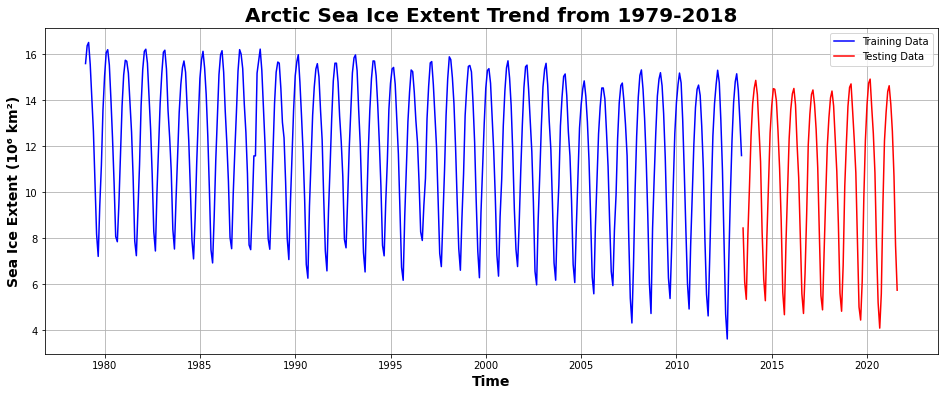

In [8]:
plt.figure(figsize = (16,6))
ax = plt.axes()
# ax.set_facecolor('#dcdcdc')

plt.title('Arctic Sea Ice Extent Trend from 1979-2018', fontsize = 20,fontweight = "bold")
plt.xlabel('Time' , fontsize = 14,fontweight = "bold")
plt.ylabel('Sea Ice Extent (10\u2076 km\u00b2)', fontsize = 14,fontweight = "bold")
plt.plot(df['sea_ice_extent'][:len(df)-len(y_test)]/10**6, 'blue', label='Training Data')
plt.plot(df['sea_ice_extent'][len(df)-len(y_test):]/10**6, 'red', label='Testing Data')
plt.legend()
plt.grid()
plt.show

In [9]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Input, LSTM, GRU, Dense

input_shape=(X.shape[1], X.shape[2])

model = Sequential()
model.add(GRU(64, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
model.add(Dropout(0.2))

model.add(GRU(128, return_sequences=True))
model.add(Dropout(0.2))

model.add(GRU(256, return_sequences=True))
model.add(Dropout(0.2))

model.add(GRU(512, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(1024, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(512, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(256, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(128))
model.add(Dropout(0.2))

model.add(Dense(64 ,  activation = 'relu'))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae', 'mse'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 20, 64)            14400     
                                                                 
 dropout (Dropout)           (None, 20, 64)            0         
                                                                 
 gru_1 (GRU)                 (None, 20, 128)           74496     
                                                                 
 dropout_1 (Dropout)         (None, 20, 128)           0         
                                                                 
 gru_2 (GRU)                 (None, 20, 256)           296448    
                                                                 
 dropout_2 (Dropout)         (None, 20, 256)           0         
                                                                 
 gru_3 (GRU)                 (None, 20, 512)           1

In [10]:
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint("weights.best.hdf5", monitor='val_mean_squared_error', verbose=1, save_best_only=True, mode='min')

callbacks_list = [checkpoint]
history = model.fit(X_train, y_train, epochs=100, batch_size=64, verbose=1, callbacks=callbacks_list, validation_split=0.1)

Epoch 1/100
5/6 [========================>.....] - ETA: 0s - loss: 0.6363 - mae: 0.6460 - mse: 0.6363

6/6 [==============================] - 21s 542ms/step - loss: 0.5908 - mae: 0.6164 - mse: 0.5908 - val_loss: 0.0759 - val_mae: 0.2247 - val_mse: 0.0759
Epoch 2/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0803 - mae: 0.2363 - mse: 0.0803

6/6 [==============================] - 0s 55ms/step - loss: 0.0806 - mae: 0.2380 - mse: 0.0806 - val_loss: 0.0855 - val_mae: 0.2283 - val_mse: 0.0855
Epoch 3/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0577 - mae: 0.1947 - mse: 0.0577

6/6 [==============================] - 0s 44ms/step - loss: 0.0562 - mae: 0.1930 - mse: 0.0562 - val_loss: 0.0756 - val_mae: 0.2051 - val_mse: 0.0756
Epoch 4/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0486 - mae: 0.1655 - mse: 0.0486

6/6 [==============================] - 0s 46ms/step - loss: 0.0511 - mae: 0.1688 - mse: 0.0511 - val_loss: 0.0748 - val_mae: 0.2191 - val_mse: 0.0748
Epoch 5/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0690 - mae: 0.2136 - mse: 0.0690

6/6 [==============================] - 0s 47ms/step - loss: 0.0699 - mae: 0.2149 - mse: 0.0699 - val_loss: 0.0869 - val_mae: 0.2242 - val_mse: 0.0869
Epoch 6/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0575 - mae: 0.2035 - mse: 0.0575

6/6 [==============================] - 0s 47ms/step - loss: 0.0576 - mae: 0.2040 - mse: 0.0576 - val_loss: 0.0714 - val_mae: 0.2233 - val_mse: 0.0714
Epoch 7/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0560 - mae: 0.1929 - mse: 0.0560

6/6 [==============================] - 0s 43ms/step - loss: 0.0559 - mae: 0.1935 - mse: 0.0559 - val_loss: 0.0598 - val_mae: 0.1959 - val_mse: 0.0598
Epoch 8/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0397 - mae: 0.1683 - mse: 0.0397

6/6 [==============================] - 0s 44ms/step - loss: 0.0384 - mae: 0.1650 - mse: 0.0384 - val_loss: 0.0895 - val_mae: 0.2340 - val_mse: 0.0895
Epoch 9/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0303 - mae: 0.1336 - mse: 0.0303

6/6 [==============================] - 0s 44ms/step - loss: 0.0293 - mae: 0.1311 - mse: 0.0293 - val_loss: 0.0669 - val_mae: 0.1965 - val_mse: 0.0669
Epoch 10/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0211 - mae: 0.1141 - mse: 0.0211

6/6 [==============================] - 0s 45ms/step - loss: 0.0205 - mae: 0.1131 - mse: 0.0205 - val_loss: 0.0249 - val_mae: 0.1222 - val_mse: 0.0249
Epoch 11/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0154 - mae: 0.0957 - mse: 0.0154

6/6 [==============================] - 0s 47ms/step - loss: 0.0150 - mae: 0.0951 - mse: 0.0150 - val_loss: 0.0162 - val_mae: 0.0959 - val_mse: 0.0162
Epoch 12/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0128 - mae: 0.0865 - mse: 0.0128

6/6 [==============================] - 0s 46ms/step - loss: 0.0131 - mae: 0.0885 - mse: 0.0131 - val_loss: 0.0211 - val_mae: 0.1123 - val_mse: 0.0211
Epoch 13/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0136 - mae: 0.0924 - mse: 0.0136

6/6 [==============================] - 0s 46ms/step - loss: 0.0138 - mae: 0.0936 - mse: 0.0138 - val_loss: 0.0074 - val_mae: 0.0628 - val_mse: 0.0074
Epoch 14/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0140 - mae: 0.0915 - mse: 0.0140

6/6 [==============================] - 0s 46ms/step - loss: 0.0141 - mae: 0.0914 - mse: 0.0141 - val_loss: 0.0130 - val_mae: 0.0762 - val_mse: 0.0130
Epoch 15/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0120 - mae: 0.0868 - mse: 0.0120

6/6 [==============================] - 0s 46ms/step - loss: 0.0119 - mae: 0.0862 - mse: 0.0119 - val_loss: 0.0163 - val_mae: 0.0893 - val_mse: 0.0163
Epoch 16/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0112 - mae: 0.0818 - mse: 0.0112

6/6 [==============================] - 0s 46ms/step - loss: 0.0111 - mae: 0.0818 - mse: 0.0111 - val_loss: 0.0168 - val_mae: 0.0985 - val_mse: 0.0168
Epoch 17/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0098 - mae: 0.0762 - mse: 0.0098

6/6 [==============================] - 0s 45ms/step - loss: 0.0098 - mae: 0.0768 - mse: 0.0098 - val_loss: 0.0213 - val_mae: 0.1081 - val_mse: 0.0213
Epoch 18/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0105 - mae: 0.0790 - mse: 0.0105

6/6 [==============================] - 0s 46ms/step - loss: 0.0109 - mae: 0.0807 - mse: 0.0109 - val_loss: 0.0334 - val_mae: 0.1645 - val_mse: 0.0334
Epoch 19/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0094 - mae: 0.0772 - mse: 0.0094

6/6 [==============================] - 0s 47ms/step - loss: 0.0096 - mae: 0.0772 - mse: 0.0096 - val_loss: 0.0238 - val_mae: 0.1129 - val_mse: 0.0238
Epoch 20/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0115 - mae: 0.0841 - mse: 0.0115

6/6 [==============================] - 0s 45ms/step - loss: 0.0116 - mae: 0.0838 - mse: 0.0116 - val_loss: 0.0066 - val_mae: 0.0534 - val_mse: 0.0066
Epoch 21/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0114 - mae: 0.0844 - mse: 0.0114

6/6 [==============================] - 0s 45ms/step - loss: 0.0111 - mae: 0.0829 - mse: 0.0111 - val_loss: 0.0130 - val_mae: 0.0830 - val_mse: 0.0130
Epoch 22/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0089 - mae: 0.0739 - mse: 0.0089

6/6 [==============================] - 0s 44ms/step - loss: 0.0091 - mae: 0.0747 - mse: 0.0091 - val_loss: 0.0140 - val_mae: 0.0918 - val_mse: 0.0140
Epoch 23/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0083 - mae: 0.0715 - mse: 0.0083

6/6 [==============================] - 0s 47ms/step - loss: 0.0086 - mae: 0.0728 - mse: 0.0086 - val_loss: 0.0118 - val_mae: 0.0798 - val_mse: 0.0118
Epoch 24/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0078 - mae: 0.0706 - mse: 0.0078

6/6 [==============================] - 0s 44ms/step - loss: 0.0083 - mae: 0.0728 - mse: 0.0083 - val_loss: 0.0143 - val_mae: 0.0907 - val_mse: 0.0143
Epoch 25/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0075 - mae: 0.0698 - mse: 0.0075

6/6 [==============================] - 0s 46ms/step - loss: 0.0079 - mae: 0.0706 - mse: 0.0079 - val_loss: 0.0115 - val_mae: 0.0796 - val_mse: 0.0115
Epoch 26/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0081 - mae: 0.0725 - mse: 0.0081

6/6 [==============================] - 0s 46ms/step - loss: 0.0085 - mae: 0.0748 - mse: 0.0085 - val_loss: 0.0340 - val_mae: 0.1722 - val_mse: 0.0340
Epoch 27/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0105 - mae: 0.0828 - mse: 0.0105

6/6 [==============================] - 0s 45ms/step - loss: 0.0104 - mae: 0.0823 - mse: 0.0104 - val_loss: 0.0258 - val_mae: 0.1368 - val_mse: 0.0258
Epoch 28/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0107 - mae: 0.0820 - mse: 0.0107

6/6 [==============================] - 0s 47ms/step - loss: 0.0106 - mae: 0.0814 - mse: 0.0106 - val_loss: 0.0138 - val_mae: 0.0881 - val_mse: 0.0138
Epoch 29/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0102 - mae: 0.0767 - mse: 0.0102

6/6 [==============================] - 0s 44ms/step - loss: 0.0100 - mae: 0.0761 - mse: 0.0100 - val_loss: 0.0121 - val_mae: 0.0847 - val_mse: 0.0121
Epoch 30/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0088 - mae: 0.0725 - mse: 0.0088

6/6 [==============================] - 0s 47ms/step - loss: 0.0087 - mae: 0.0730 - mse: 0.0087 - val_loss: 0.0100 - val_mae: 0.0716 - val_mse: 0.0100
Epoch 31/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0079 - mae: 0.0709 - mse: 0.0079

6/6 [==============================] - 0s 46ms/step - loss: 0.0080 - mae: 0.0708 - mse: 0.0080 - val_loss: 0.0091 - val_mae: 0.0709 - val_mse: 0.0091
Epoch 32/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0085 - mae: 0.0736 - mse: 0.0085

6/6 [==============================] - 0s 44ms/step - loss: 0.0084 - mae: 0.0739 - mse: 0.0084 - val_loss: 0.0101 - val_mae: 0.0736 - val_mse: 0.0101
Epoch 33/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0080 - mae: 0.0696 - mse: 0.0080

6/6 [==============================] - 0s 46ms/step - loss: 0.0084 - mae: 0.0713 - mse: 0.0084 - val_loss: 0.0098 - val_mae: 0.0725 - val_mse: 0.0098
Epoch 34/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0068 - mae: 0.0634 - mse: 0.0068

6/6 [==============================] - 0s 45ms/step - loss: 0.0068 - mae: 0.0633 - mse: 0.0068 - val_loss: 0.0167 - val_mae: 0.1060 - val_mse: 0.0167
Epoch 35/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0070 - mae: 0.0674 - mse: 0.0070

6/6 [==============================] - 0s 48ms/step - loss: 0.0070 - mae: 0.0673 - mse: 0.0070 - val_loss: 0.0207 - val_mae: 0.1345 - val_mse: 0.0207
Epoch 36/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0070 - mae: 0.0662 - mse: 0.0070

6/6 [==============================] - 0s 47ms/step - loss: 0.0069 - mae: 0.0656 - mse: 0.0069 - val_loss: 0.0123 - val_mae: 0.0872 - val_mse: 0.0123
Epoch 37/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0063 - mae: 0.0627 - mse: 0.0063

6/6 [==============================] - 0s 47ms/step - loss: 0.0065 - mae: 0.0638 - mse: 0.0065 - val_loss: 0.0126 - val_mae: 0.0801 - val_mse: 0.0126
Epoch 38/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0058 - mae: 0.0577 - mse: 0.0058

6/6 [==============================] - 0s 47ms/step - loss: 0.0058 - mae: 0.0574 - mse: 0.0058 - val_loss: 0.0077 - val_mae: 0.0535 - val_mse: 0.0077
Epoch 39/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0060 - mae: 0.0632 - mse: 0.0060

6/6 [==============================] - 0s 48ms/step - loss: 0.0061 - mae: 0.0638 - mse: 0.0061 - val_loss: 0.0070 - val_mae: 0.0663 - val_mse: 0.0070
Epoch 40/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0074 - mae: 0.0689 - mse: 0.0074

6/6 [==============================] - 0s 47ms/step - loss: 0.0071 - mae: 0.0675 - mse: 0.0071 - val_loss: 0.0113 - val_mae: 0.0893 - val_mse: 0.0113
Epoch 41/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0057 - mae: 0.0606 - mse: 0.0057

6/6 [==============================] - 0s 47ms/step - loss: 0.0056 - mae: 0.0597 - mse: 0.0056 - val_loss: 0.0106 - val_mae: 0.0762 - val_mse: 0.0106
Epoch 42/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0047 - mae: 0.0531 - mse: 0.0047

6/6 [==============================] - 0s 47ms/step - loss: 0.0048 - mae: 0.0528 - mse: 0.0048 - val_loss: 0.0081 - val_mae: 0.0768 - val_mse: 0.0081
Epoch 43/100
6/6 [==============================] - ETA: 0s - loss: 0.0053 - mae: 0.0570 - mse: 0.0053

6/6 [==============================] - 0s 50ms/step - loss: 0.0053 - mae: 0.0570 - mse: 0.0053 - val_loss: 0.0104 - val_mae: 0.0753 - val_mse: 0.0104
Epoch 44/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0064 - mae: 0.0600 - mse: 0.0064

6/6 [==============================] - 0s 47ms/step - loss: 0.0061 - mae: 0.0587 - mse: 0.0061 - val_loss: 0.0060 - val_mae: 0.0564 - val_mse: 0.0060
Epoch 45/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0059 - mae: 0.0603 - mse: 0.0059

6/6 [==============================] - 0s 47ms/step - loss: 0.0060 - mae: 0.0612 - mse: 0.0060 - val_loss: 0.0076 - val_mae: 0.0676 - val_mse: 0.0076
Epoch 46/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0060 - mae: 0.0615 - mse: 0.0060

6/6 [==============================] - 0s 44ms/step - loss: 0.0062 - mae: 0.0624 - mse: 0.0062 - val_loss: 0.0090 - val_mae: 0.0689 - val_mse: 0.0090
Epoch 47/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0062 - mae: 0.0612 - mse: 0.0062

6/6 [==============================] - 0s 47ms/step - loss: 0.0063 - mae: 0.0617 - mse: 0.0063 - val_loss: 0.0076 - val_mae: 0.0659 - val_mse: 0.0076
Epoch 48/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0053 - mae: 0.0566 - mse: 0.0053

6/6 [==============================] - 0s 47ms/step - loss: 0.0053 - mae: 0.0575 - mse: 0.0053 - val_loss: 0.0125 - val_mae: 0.0732 - val_mse: 0.0125
Epoch 49/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0056 - mae: 0.0586 - mse: 0.0056

6/6 [==============================] - 0s 45ms/step - loss: 0.0056 - mae: 0.0583 - mse: 0.0056 - val_loss: 0.0091 - val_mae: 0.0715 - val_mse: 0.0091
Epoch 50/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0050 - mae: 0.0555 - mse: 0.0050

6/6 [==============================] - 0s 45ms/step - loss: 0.0050 - mae: 0.0557 - mse: 0.0050 - val_loss: 0.0126 - val_mae: 0.0818 - val_mse: 0.0126
Epoch 51/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0060 - mae: 0.0614 - mse: 0.0060

6/6 [==============================] - 0s 44ms/step - loss: 0.0059 - mae: 0.0611 - mse: 0.0059 - val_loss: 0.0048 - val_mae: 0.0498 - val_mse: 0.0048
Epoch 52/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0040 - mae: 0.0488 - mse: 0.0040

6/6 [==============================] - 0s 47ms/step - loss: 0.0040 - mae: 0.0492 - mse: 0.0040 - val_loss: 0.0073 - val_mae: 0.0594 - val_mse: 0.0073
Epoch 53/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0040 - mae: 0.0486 - mse: 0.0040

6/6 [==============================] - 0s 47ms/step - loss: 0.0040 - mae: 0.0488 - mse: 0.0040 - val_loss: 0.0040 - val_mae: 0.0459 - val_mse: 0.0040
Epoch 54/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0044 - mae: 0.0538 - mse: 0.0044

6/6 [==============================] - 0s 48ms/step - loss: 0.0046 - mae: 0.0543 - mse: 0.0046 - val_loss: 0.0085 - val_mae: 0.0675 - val_mse: 0.0085
Epoch 55/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0039 - mae: 0.0496 - mse: 0.0039

6/6 [==============================] - 0s 45ms/step - loss: 0.0040 - mae: 0.0501 - mse: 0.0040 - val_loss: 0.0035 - val_mae: 0.0426 - val_mse: 0.0035
Epoch 56/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0037 - mae: 0.0475 - mse: 0.0037

6/6 [==============================] - 0s 47ms/step - loss: 0.0038 - mae: 0.0479 - mse: 0.0038 - val_loss: 0.0112 - val_mae: 0.0876 - val_mse: 0.0112
Epoch 57/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0050 - mae: 0.0564 - mse: 0.0050

6/6 [==============================] - 0s 46ms/step - loss: 0.0050 - mae: 0.0562 - mse: 0.0050 - val_loss: 0.0081 - val_mae: 0.0741 - val_mse: 0.0081
Epoch 58/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0043 - mae: 0.0524 - mse: 0.0043

6/6 [==============================] - 0s 45ms/step - loss: 0.0042 - mae: 0.0518 - mse: 0.0042 - val_loss: 0.0097 - val_mae: 0.0758 - val_mse: 0.0097
Epoch 59/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0041 - mae: 0.0508 - mse: 0.0041

6/6 [==============================] - 0s 47ms/step - loss: 0.0041 - mae: 0.0502 - mse: 0.0041 - val_loss: 0.0057 - val_mae: 0.0631 - val_mse: 0.0057
Epoch 60/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0041 - mae: 0.0509 - mse: 0.0041

6/6 [==============================] - 0s 47ms/step - loss: 0.0046 - mae: 0.0535 - mse: 0.0046 - val_loss: 0.0073 - val_mae: 0.0612 - val_mse: 0.0073
Epoch 61/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0043 - mae: 0.0515 - mse: 0.0043

6/6 [==============================] - 0s 44ms/step - loss: 0.0043 - mae: 0.0514 - mse: 0.0043 - val_loss: 0.0051 - val_mae: 0.0496 - val_mse: 0.0051
Epoch 62/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0036 - mae: 0.0466 - mse: 0.0036

6/6 [==============================] - 0s 46ms/step - loss: 0.0038 - mae: 0.0479 - mse: 0.0038 - val_loss: 0.0047 - val_mae: 0.0498 - val_mse: 0.0047
Epoch 63/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0047 - mae: 0.0553 - mse: 0.0047

6/6 [==============================] - 0s 49ms/step - loss: 0.0045 - mae: 0.0542 - mse: 0.0045 - val_loss: 0.0088 - val_mae: 0.0823 - val_mse: 0.0088
Epoch 64/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0062 - mae: 0.0645 - mse: 0.0062

6/6 [==============================] - 0s 47ms/step - loss: 0.0060 - mae: 0.0629 - mse: 0.0060 - val_loss: 0.0070 - val_mae: 0.0694 - val_mse: 0.0070
Epoch 65/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0049 - mae: 0.0557 - mse: 0.0049

6/6 [==============================] - 0s 47ms/step - loss: 0.0053 - mae: 0.0578 - mse: 0.0053 - val_loss: 0.0073 - val_mae: 0.0645 - val_mse: 0.0073
Epoch 66/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0055 - mae: 0.0591 - mse: 0.0055

6/6 [==============================] - 0s 47ms/step - loss: 0.0052 - mae: 0.0576 - mse: 0.0052 - val_loss: 0.0097 - val_mae: 0.0842 - val_mse: 0.0097
Epoch 67/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0047 - mae: 0.0538 - mse: 0.0047

6/6 [==============================] - 0s 47ms/step - loss: 0.0047 - mae: 0.0541 - mse: 0.0047 - val_loss: 0.0041 - val_mae: 0.0524 - val_mse: 0.0041
Epoch 68/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0041 - mae: 0.0497 - mse: 0.0041

6/6 [==============================] - 0s 47ms/step - loss: 0.0041 - mae: 0.0498 - mse: 0.0041 - val_loss: 0.0069 - val_mae: 0.0570 - val_mse: 0.0069
Epoch 69/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0043 - mae: 0.0521 - mse: 0.0043

6/6 [==============================] - 0s 45ms/step - loss: 0.0043 - mae: 0.0525 - mse: 0.0043 - val_loss: 0.0026 - val_mae: 0.0427 - val_mse: 0.0026
Epoch 70/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0039 - mae: 0.0486 - mse: 0.0039

6/6 [==============================] - 0s 46ms/step - loss: 0.0040 - mae: 0.0493 - mse: 0.0040 - val_loss: 0.0026 - val_mae: 0.0373 - val_mse: 0.0026
Epoch 71/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0030 - mae: 0.0429 - mse: 0.0030

6/6 [==============================] - 0s 46ms/step - loss: 0.0030 - mae: 0.0432 - mse: 0.0030 - val_loss: 0.0032 - val_mae: 0.0412 - val_mse: 0.0032
Epoch 72/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0031 - mae: 0.0455 - mse: 0.0031

6/6 [==============================] - 0s 45ms/step - loss: 0.0031 - mae: 0.0446 - mse: 0.0031 - val_loss: 0.0037 - val_mae: 0.0457 - val_mse: 0.0037
Epoch 73/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0032 - mae: 0.0450 - mse: 0.0032

6/6 [==============================] - 0s 46ms/step - loss: 0.0033 - mae: 0.0456 - mse: 0.0033 - val_loss: 0.0029 - val_mae: 0.0404 - val_mse: 0.0029
Epoch 74/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0025 - mae: 0.0400 - mse: 0.0025

6/6 [==============================] - 0s 48ms/step - loss: 0.0026 - mae: 0.0403 - mse: 0.0026 - val_loss: 0.0032 - val_mae: 0.0415 - val_mse: 0.0032
Epoch 75/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0026 - mae: 0.0411 - mse: 0.0026

6/6 [==============================] - 0s 46ms/step - loss: 0.0027 - mae: 0.0420 - mse: 0.0027 - val_loss: 0.0029 - val_mae: 0.0420 - val_mse: 0.0029
Epoch 76/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0026 - mae: 0.0413 - mse: 0.0026

6/6 [==============================] - 0s 45ms/step - loss: 0.0025 - mae: 0.0404 - mse: 0.0025 - val_loss: 0.0025 - val_mae: 0.0392 - val_mse: 0.0025
Epoch 77/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0036 - mae: 0.0478 - mse: 0.0036

6/6 [==============================] - 0s 47ms/step - loss: 0.0035 - mae: 0.0471 - mse: 0.0035 - val_loss: 0.0042 - val_mae: 0.0517 - val_mse: 0.0042
Epoch 78/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0030 - mae: 0.0441 - mse: 0.0030

6/6 [==============================] - 0s 48ms/step - loss: 0.0031 - mae: 0.0448 - mse: 0.0031 - val_loss: 0.0039 - val_mae: 0.0462 - val_mse: 0.0039
Epoch 79/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0037 - mae: 0.0484 - mse: 0.0037

6/6 [==============================] - 0s 45ms/step - loss: 0.0036 - mae: 0.0479 - mse: 0.0036 - val_loss: 0.0039 - val_mae: 0.0482 - val_mse: 0.0039
Epoch 80/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0033 - mae: 0.0446 - mse: 0.0033

6/6 [==============================] - 0s 45ms/step - loss: 0.0034 - mae: 0.0452 - mse: 0.0034 - val_loss: 0.0025 - val_mae: 0.0378 - val_mse: 0.0025
Epoch 81/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0033 - mae: 0.0470 - mse: 0.0033

6/6 [==============================] - 0s 47ms/step - loss: 0.0034 - mae: 0.0472 - mse: 0.0034 - val_loss: 0.0038 - val_mae: 0.0462 - val_mse: 0.0038
Epoch 82/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0024 - mae: 0.0398 - mse: 0.0024

6/6 [==============================] - 0s 47ms/step - loss: 0.0026 - mae: 0.0411 - mse: 0.0026 - val_loss: 0.0029 - val_mae: 0.0439 - val_mse: 0.0029
Epoch 83/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0025 - mae: 0.0397 - mse: 0.0025

6/6 [==============================] - 0s 44ms/step - loss: 0.0024 - mae: 0.0391 - mse: 0.0024 - val_loss: 0.0048 - val_mae: 0.0553 - val_mse: 0.0048
Epoch 84/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0036 - mae: 0.0473 - mse: 0.0036

6/6 [==============================] - 0s 46ms/step - loss: 0.0036 - mae: 0.0479 - mse: 0.0036 - val_loss: 0.0031 - val_mae: 0.0432 - val_mse: 0.0031
Epoch 85/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0026 - mae: 0.0412 - mse: 0.0026

6/6 [==============================] - 0s 46ms/step - loss: 0.0029 - mae: 0.0429 - mse: 0.0029 - val_loss: 0.0031 - val_mae: 0.0384 - val_mse: 0.0031
Epoch 86/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0030 - mae: 0.0432 - mse: 0.0030

6/6 [==============================] - 0s 46ms/step - loss: 0.0030 - mae: 0.0436 - mse: 0.0030 - val_loss: 0.0037 - val_mae: 0.0473 - val_mse: 0.0037
Epoch 87/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0026 - mae: 0.0398 - mse: 0.0026

6/6 [==============================] - 0s 49ms/step - loss: 0.0026 - mae: 0.0401 - mse: 0.0026 - val_loss: 0.0023 - val_mae: 0.0367 - val_mse: 0.0023
Epoch 88/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0026 - mae: 0.0393 - mse: 0.0026

6/6 [==============================] - 0s 46ms/step - loss: 0.0026 - mae: 0.0394 - mse: 0.0026 - val_loss: 0.0046 - val_mae: 0.0527 - val_mse: 0.0046
Epoch 89/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0030 - mae: 0.0435 - mse: 0.0030

6/6 [==============================] - 0s 48ms/step - loss: 0.0030 - mae: 0.0437 - mse: 0.0030 - val_loss: 0.0018 - val_mae: 0.0300 - val_mse: 0.0018
Epoch 90/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0026 - mae: 0.0410 - mse: 0.0026

6/6 [==============================] - 0s 48ms/step - loss: 0.0026 - mae: 0.0411 - mse: 0.0026 - val_loss: 0.0036 - val_mae: 0.0452 - val_mse: 0.0036
Epoch 91/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0030 - mae: 0.0440 - mse: 0.0030

6/6 [==============================] - 0s 47ms/step - loss: 0.0029 - mae: 0.0430 - mse: 0.0029 - val_loss: 0.0041 - val_mae: 0.0515 - val_mse: 0.0041
Epoch 92/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0028 - mae: 0.0413 - mse: 0.0028

6/6 [==============================] - 0s 47ms/step - loss: 0.0028 - mae: 0.0413 - mse: 0.0028 - val_loss: 0.0036 - val_mae: 0.0471 - val_mse: 0.0036
Epoch 93/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0031 - mae: 0.0442 - mse: 0.0031

6/6 [==============================] - 0s 46ms/step - loss: 0.0030 - mae: 0.0438 - mse: 0.0030 - val_loss: 0.0028 - val_mae: 0.0432 - val_mse: 0.0028
Epoch 94/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0030 - mae: 0.0420 - mse: 0.0030

6/6 [==============================] - 0s 45ms/step - loss: 0.0028 - mae: 0.0413 - mse: 0.0028 - val_loss: 0.0019 - val_mae: 0.0332 - val_mse: 0.0019
Epoch 95/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0030 - mae: 0.0439 - mse: 0.0030

6/6 [==============================] - 0s 46ms/step - loss: 0.0029 - mae: 0.0429 - mse: 0.0029 - val_loss: 0.0042 - val_mae: 0.0505 - val_mse: 0.0042
Epoch 96/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0034 - mae: 0.0463 - mse: 0.0034

6/6 [==============================] - 0s 47ms/step - loss: 0.0033 - mae: 0.0457 - mse: 0.0033 - val_loss: 0.0031 - val_mae: 0.0441 - val_mse: 0.0031
Epoch 97/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0035 - mae: 0.0471 - mse: 0.0035

6/6 [==============================] - 0s 46ms/step - loss: 0.0034 - mae: 0.0468 - mse: 0.0034 - val_loss: 0.0030 - val_mae: 0.0443 - val_mse: 0.0030
Epoch 98/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0030 - mae: 0.0423 - mse: 0.0030

6/6 [==============================] - 0s 46ms/step - loss: 0.0030 - mae: 0.0425 - mse: 0.0030 - val_loss: 0.0027 - val_mae: 0.0441 - val_mse: 0.0027
Epoch 99/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0032 - mae: 0.0457 - mse: 0.0032

6/6 [==============================] - 0s 46ms/step - loss: 0.0034 - mae: 0.0465 - mse: 0.0034 - val_loss: 0.0030 - val_mae: 0.0427 - val_mse: 0.0030
Epoch 100/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0028 - mae: 0.0421 - mse: 0.0028

6/6 [==============================] - 0s 47ms/step - loss: 0.0028 - mae: 0.0419 - mse: 0.0028 - val_loss: 0.0035 - val_mae: 0.0478 - val_mse: 0.0035


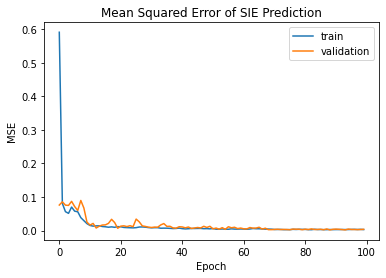

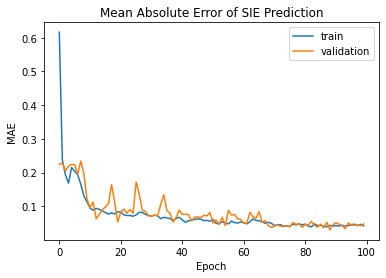

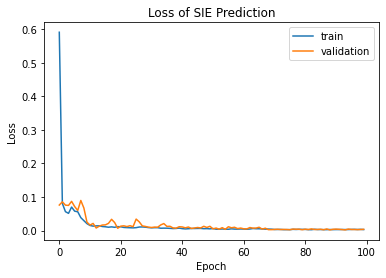

In [11]:
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('Mean Squared Error of SIE Prediction')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Mean Absolute Error of SIE Prediction')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss of SIE Prediction')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [12]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from numpy import sqrt

#model.load_weights("weights.best.hdf5")

cols = len(df.columns)
pred = model.predict(X_test)

predicted_dataset = dataset
predicted_dataset[len(predicted_dataset)-len(pred):, cols-1] = pred[:, 0]
scaled_predicted_dataset = scaler.inverse_transform(predicted_dataset)

predicted_df = df.copy()
predicted_df['sea_ice_extent'][len(predicted_dataset)-len(pred):] = scaled_predicted_dataset[len(predicted_dataset)-len(pred):, cols-1]

predictions = pd.DataFrame()
predictions['predicted'] = (predicted_df['sea_ice_extent'][len(predicted_dataset)-len(pred):])
predictions['actual'] = (df['sea_ice_extent'][len(predicted_dataset)-len(pred):])
predictions = predictions.astype(float)

4/4 [==============================] - 2s 20ms/step


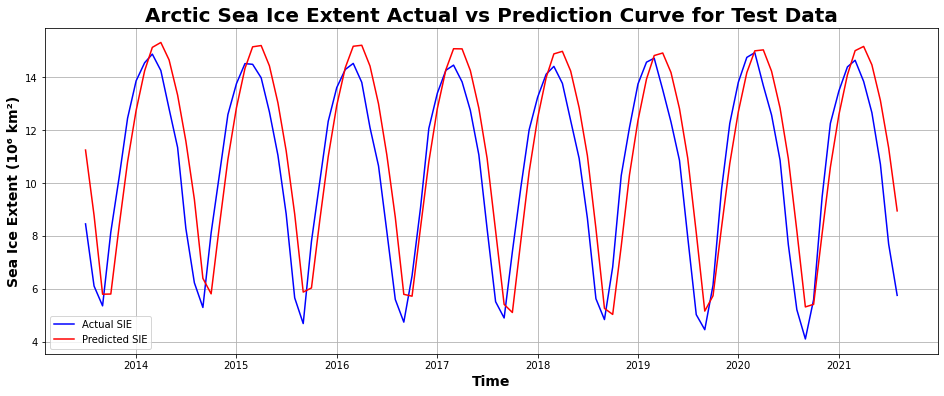

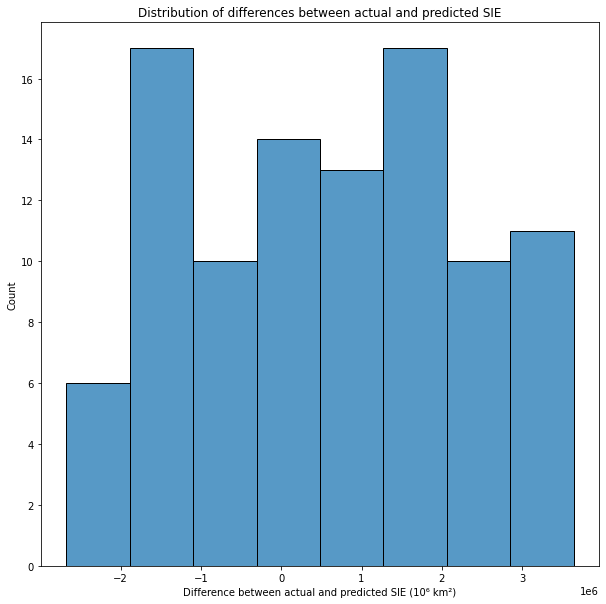

MSE :  3227517419062.199 (10⁶ km²)
MSPE : 5.499 %
RMSE :  1796529.270304884 (10⁶ km²)
RMSPE : 23.451 %
MAE :  1546135.3265306123 (10⁶ km²)
MAPE :  15.834 %
R2 :  70.568


In [13]:
plt.figure(figsize = (16,6))
ax = plt.axes()
# ax.set_facecolor('#dcdcdc')

plt.title('Arctic Sea Ice Extent Actual vs Prediction Curve for Test Data', fontsize = 20,fontweight = "bold")
plt.xlabel('Time' , fontsize = 14,fontweight = "bold")
plt.ylabel('Sea Ice Extent (10\u2076 km\u00b2)', fontsize = 14,fontweight = "bold")
plt.plot(predictions['actual']/10**6, 'blue', label='Actual SIE')
plt.plot(predictions['predicted']/10**6, 'red', label='Predicted SIE')
plt.legend()
plt.grid()
plt.show

predictions['diff'] = predictions['predicted'] - predictions['actual']
plt.figure(figsize=(10,10))
plt.xlabel('Difference between actual and predicted SIE (10\u2076 km\u00b2)')
sns.histplot(predictions['diff'])
plt.title('Distribution of differences between actual and predicted SIE')
plt.show()

mspe = (np.mean(np.square((predictions['actual'].values - predictions['predicted'].values) / predictions['actual'].values))) * 100
rmspe = (np.sqrt(np.mean(np.square((predictions['actual'].values - predictions['predicted'].values) / predictions['actual'].values)))) * 100

print("MSE : ", mean_squared_error(predictions['predicted'].values, predictions['actual'].values), "(10\u2076 km\u00b2)")
print("MSPE :", round(mspe,3), "%")
print("RMSE : ", sqrt(mean_squared_error(predictions['predicted'].values, predictions['actual'].values)), "(10\u2076 km\u00b2)")
print("RMSPE :", round(rmspe,3), "%")
print("MAE : ", mean_absolute_error(predictions['predicted'].values, predictions['actual'].values), "(10\u2076 km\u00b2)")
print("MAPE : ", round(mean_absolute_percentage_error(predictions['predicted'].values, predictions['actual'].values)*100,3), "%")
print("R2 : ", round(r2_score(predictions['predicted'].values, predictions['actual'].values)*100,3))

In [14]:
# while True:pass